In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

c:\Users\Branko\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load datasets

In [3]:
dataset_path = '../../dataset/additional_datasets/'
dataset_name = 'Breast_GSE45827'
dataset_norm_suffix = '_norm'
dataset_pca_suffix = '_pca'
models_path = 'saved_models/XGBoost/'

with open('../../preprocessing/class_mapping.pickle', 'rb') as handle:
    class_mapping = pickle.load(handle)

In [4]:
df_norm = pd.read_csv(dataset_path + dataset_name + dataset_norm_suffix + '.csv', index_col=0)
X_norm = df_norm.drop('type', axis=1)
y_norm = df_norm.type

### Create SMOTE and PCA datasets

In [5]:
PCA_COMPONENTS = 90

def pca_dataset(X_train, X_test):
    pca = PCA(n_components=PCA_COMPONENTS)
    pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca

In [6]:
def smote_dataset(X_train, y_train):
    smt = SMOTE()
    X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

    return X_train_smote, y_train_smote

#### Experiment with GridSearch

In [7]:
def start_gridsearch(X, y, oversampling=False, pca=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if oversampling:
        X_train, y_train = smote_dataset(X_train, y_train)
    if pca:
        X_train, X_test = pca_dataset(X_train, X_test)
    
    n_estimators = [100, 500, 1000]
    max_depth = [3, 5, 6, 10]
    learning_rate = [0.0001, 0.01]
    param_grid = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
    
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    estimator = GridSearchCV(model, param_grid, cv=5, verbose=4)
    grid_result = estimator.fit(X_train, y_train)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    print(grid_result.best_params_)

In [8]:
# estimator_norm = start_gridsearch(X_norm, y_norm, oversampling=False, pca=False)

In [9]:
# estimator_pca = start_gridsearch(X_norm, y_norm, oversampling=False, pca=True)

## Train

In [26]:
def train(X, y, params={'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}, oversampling=False, pca=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if oversampling:
        X_train, y_train = smote_dataset(X_train, y_train)
    if pca:
        X_train, X_test = pca_dataset(X_train, X_test)
    
    # create model instance
    model = XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    # fit model
    model.fit(X_train, y_train)

    print('Training f1: ', f1_score(y_train, model.predict(X_train), average='weighted'))
    print('Test f1: ', f1_score(y_test, model.predict(X_test), average='weighted'))

    preds = model.predict(X_test)
    return model, preds, y_test

In [45]:
norm_model, norm_pred, norm_true = train(X_norm, y_norm, params={'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}, oversampling=False, pca=False)
pca_model, pca_pred, pca_true = train(X_norm, y_norm, params={'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}, oversampling=False, pca=True)

c:\Users\Branko\miniconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training f1:  1.0


c:\Users\Branko\miniconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Test f1:  0.9354838709677419


c:\Users\Branko\miniconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training f1:  1.0
Test f1:  0.9339507125585224


In [12]:
norm_res_model, norm_res_pred, norm_res_true = train(X_norm, y_norm, params={'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}, oversampling=True, pca=False)
pca_res_model, pca_res_pred, pca_res_true = train(X_norm, y_norm, params={'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}, oversampling=True, pca=True)

c:\Users\Branko\miniconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Results

In [28]:
f1_results = {
    'norm': f1_score(norm_true, norm_pred, average='weighted') * 100,
    'pca': f1_score(pca_true, pca_pred, average='weighted') * 100,
    'norm_res': f1_score(norm_res_true, norm_res_pred, average='weighted') * 100,
    'pca_res': f1_score(pca_res_true, pca_res_pred, average='weighted') * 100
}
acc_results = {
    'norm': accuracy_score(norm_true, norm_pred) * 100,
    'pca': accuracy_score(pca_true, pca_pred) * 100,
    'norm_res': accuracy_score(norm_res_true, norm_res_pred) * 100,
    'pca_res': accuracy_score(pca_res_true, pca_res_pred) * 100
}

In [29]:
# Original dataset
norm_acc = accuracy_score(norm_true, norm_pred)
norm_f1 = f1_score(norm_true, norm_pred, average='weighted')
pca_acc = accuracy_score(pca_true, pca_pred)
pca_f1 = f1_score(pca_true, pca_pred, average='weighted')

print('Accuracy of normalized dataset: ', f'{norm_acc * 100:.2f} %')
print('F1 Score of normalized dataset: ', f'{norm_f1 * 100:.2f} %')
print('Accuracy of PCA dataset: ', f'{pca_acc * 100:.2f} %')
print('F1 Score of PCA dataset: ', f'{pca_f1 * 100:.2f} %')

Accuracy of normalized dataset:  93.55 %
F1 Score of normalized dataset:  93.55 %
Accuracy of PCA dataset:  90.32 %
F1 Score of PCA dataset:  90.45 %


In [30]:
# Oversampled dataset
norm_res_acc = accuracy_score(norm_res_true, norm_res_pred)
norm_res_f1 = f1_score(norm_res_true, norm_res_pred, average='weighted')
pca_res_acc = accuracy_score(pca_res_true, pca_res_pred)
pca_res_f1 = f1_score(pca_res_true, pca_res_pred, average='weighted')

print('Accuracy of normalized oversampled dataset: ', f'{norm_res_acc * 100:.2f} %')
print('F1 Score of normalized oversampled dataset: ', f'{norm_res_f1 * 100:.2f} %')
print('Accuracy of PCA oversampled dataset: ', f'{pca_res_acc * 100:.2f} %')
print('F1 Score of PCA oversampled dataset: ', f'{pca_res_f1 * 100:.2f} %')

Accuracy of normalized oversampled dataset:  87.10 %
F1 Score of normalized oversampled dataset:  86.99 %
Accuracy of PCA oversampled dataset:  77.42 %
F1 Score of PCA oversampled dataset:  77.48 %


## Plot

0    10
5     7
2     5
1     5
4     3
3     1
Name: type, dtype: int64


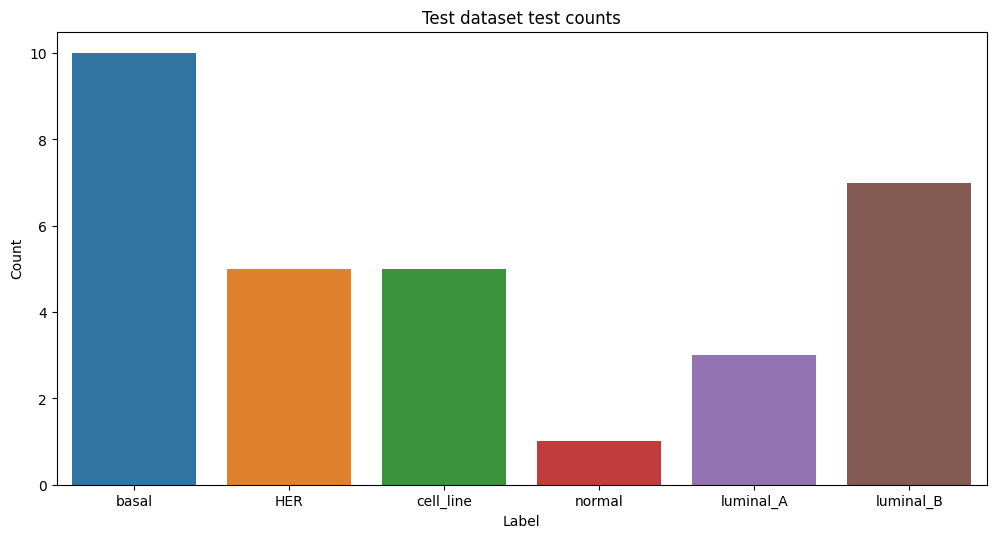

In [33]:
# Check how much values does each label have in test set
test_counts = norm_true.value_counts()
print(test_counts)

# plot test counts
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.xticks(range(len(class_mapping)), class_mapping.keys())
plt.title('Test dataset test counts')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

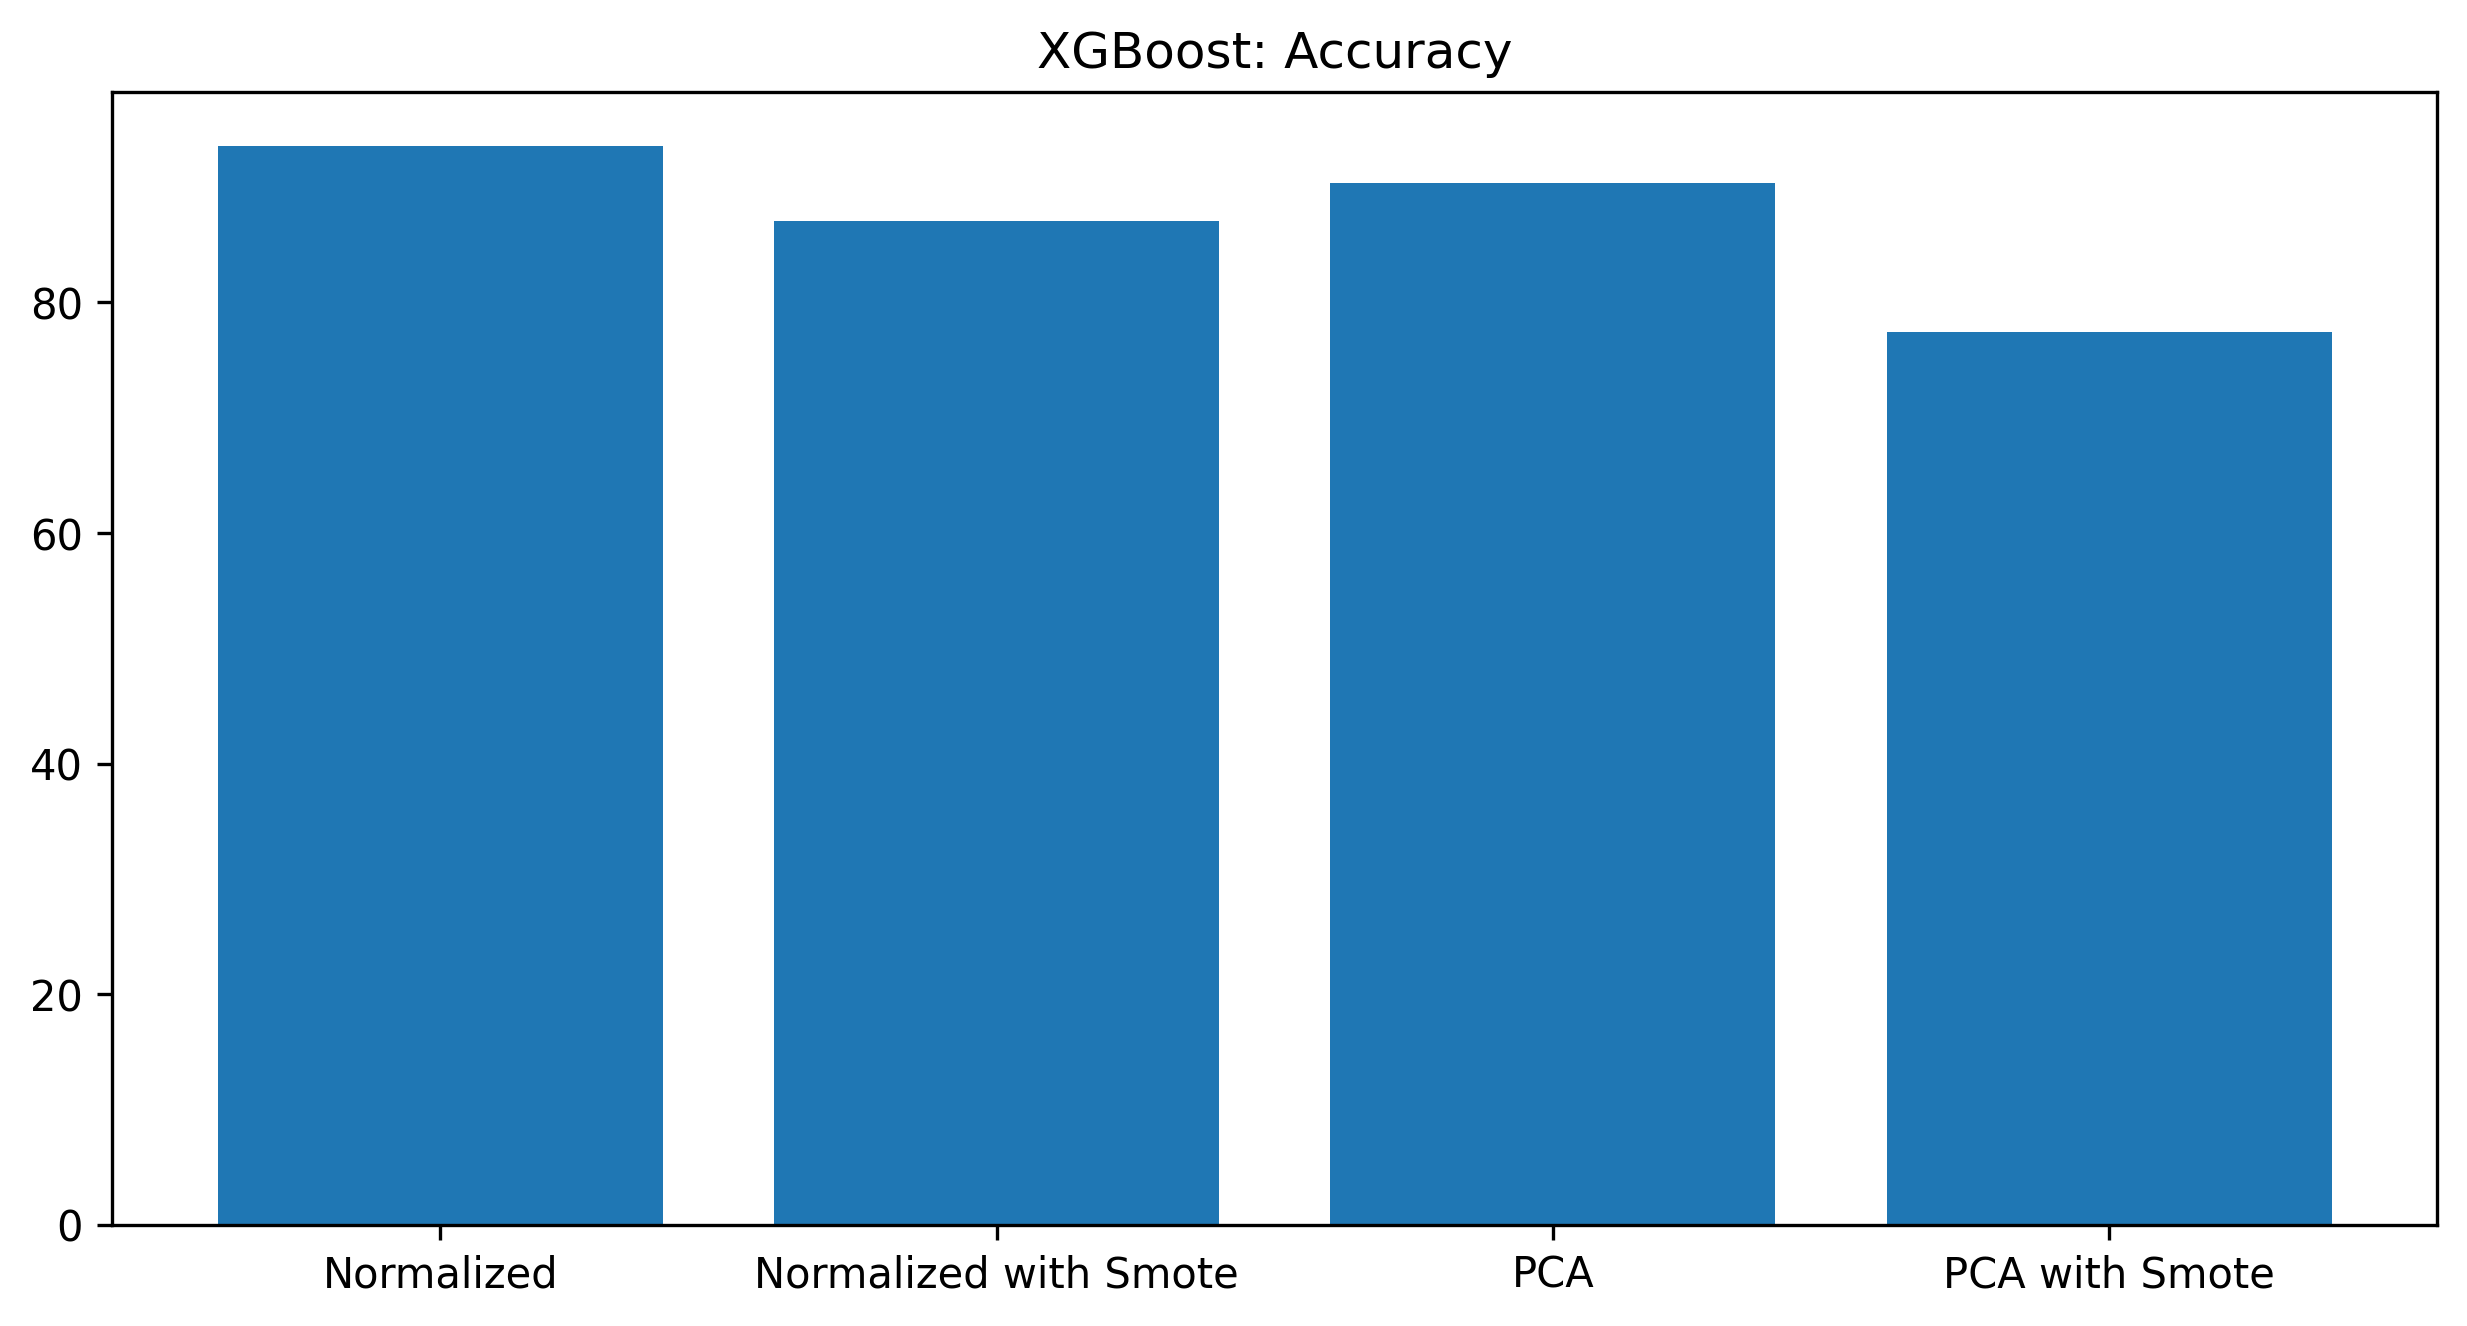

In [43]:
# Plot accuracy

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        norm_acc * 100,
        norm_res_acc * 100,
        pca_acc * 100,
        pca_res_acc * 100
    ]
)
plt.title('XGBoost: Accuracy')

# save figure
if not os.path.exists('../../figures/XGBoost'):
    os.makedirs('../../figures/XGBoost')

plt.savefig('../../figures/XGBoost/XGBoost Accuracy.png', dpi=300)

plt.show()

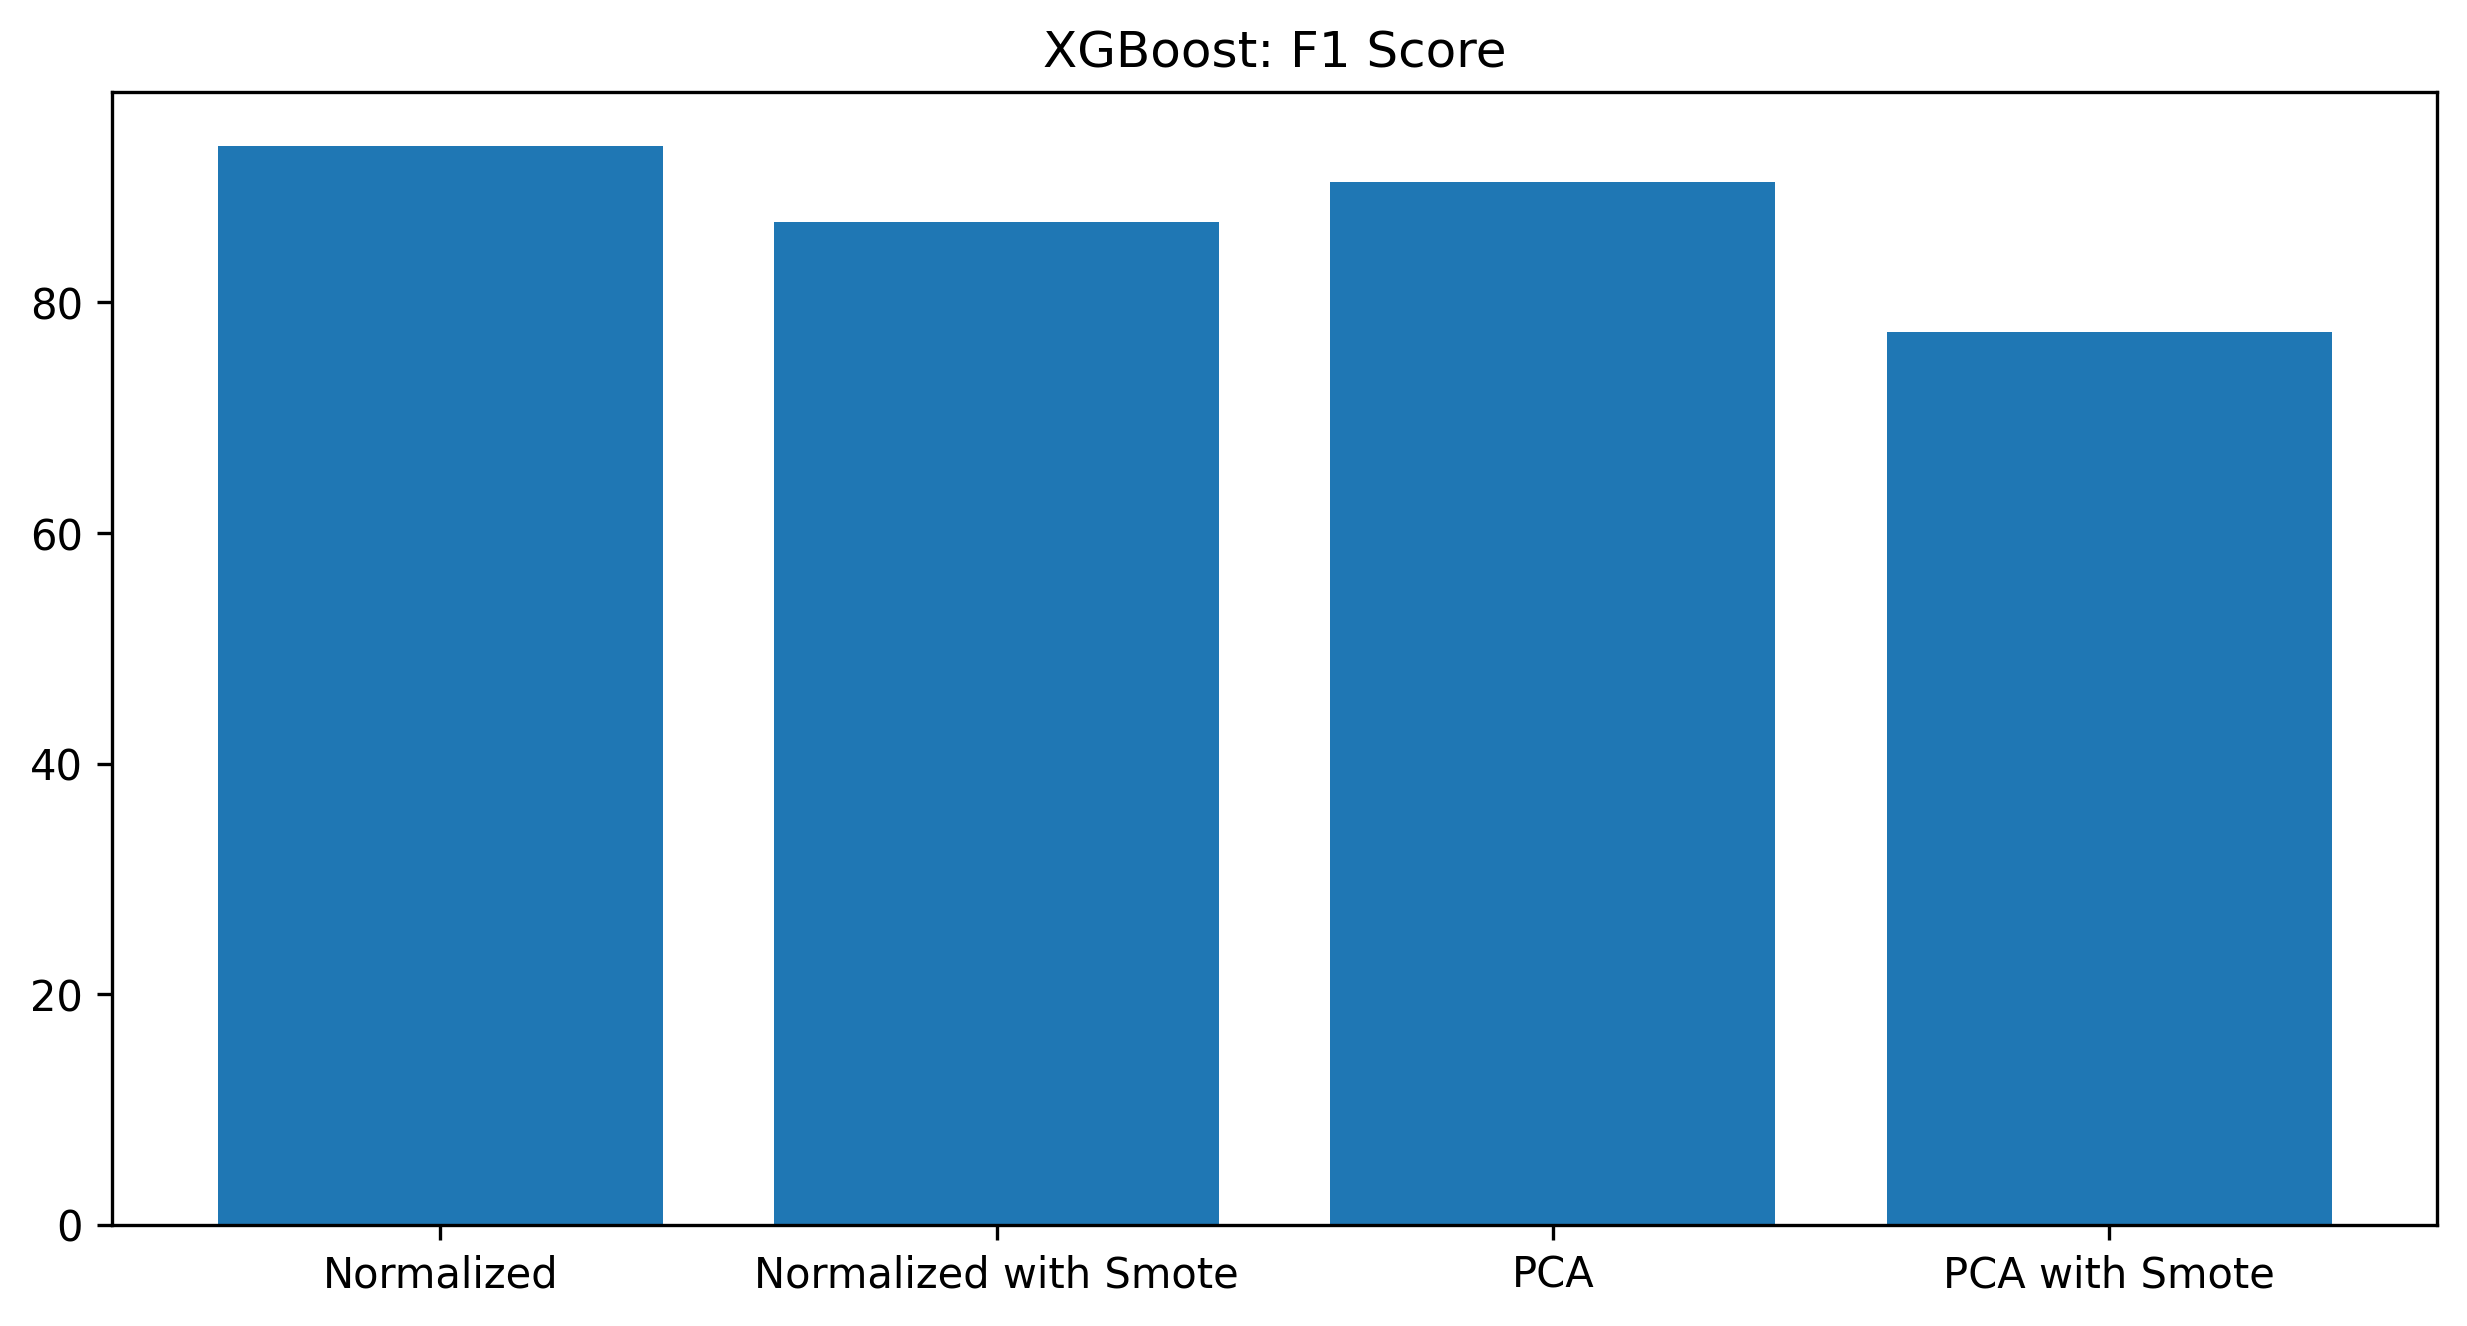

In [40]:
# Plot F1 score

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        norm_f1 * 100,
        norm_res_f1 * 100,
        pca_f1 * 100,
        pca_res_f1 * 100
    ]
)
plt.title('XGBoost: F1 Score')

# save figure
if not os.path.exists('../../figures/XGBoost'):
    os.makedirs('../../figures/XGBoost')

plt.savefig('../../figures/XGBoost/XGBoost F1.png', dpi=300)

plt.show()

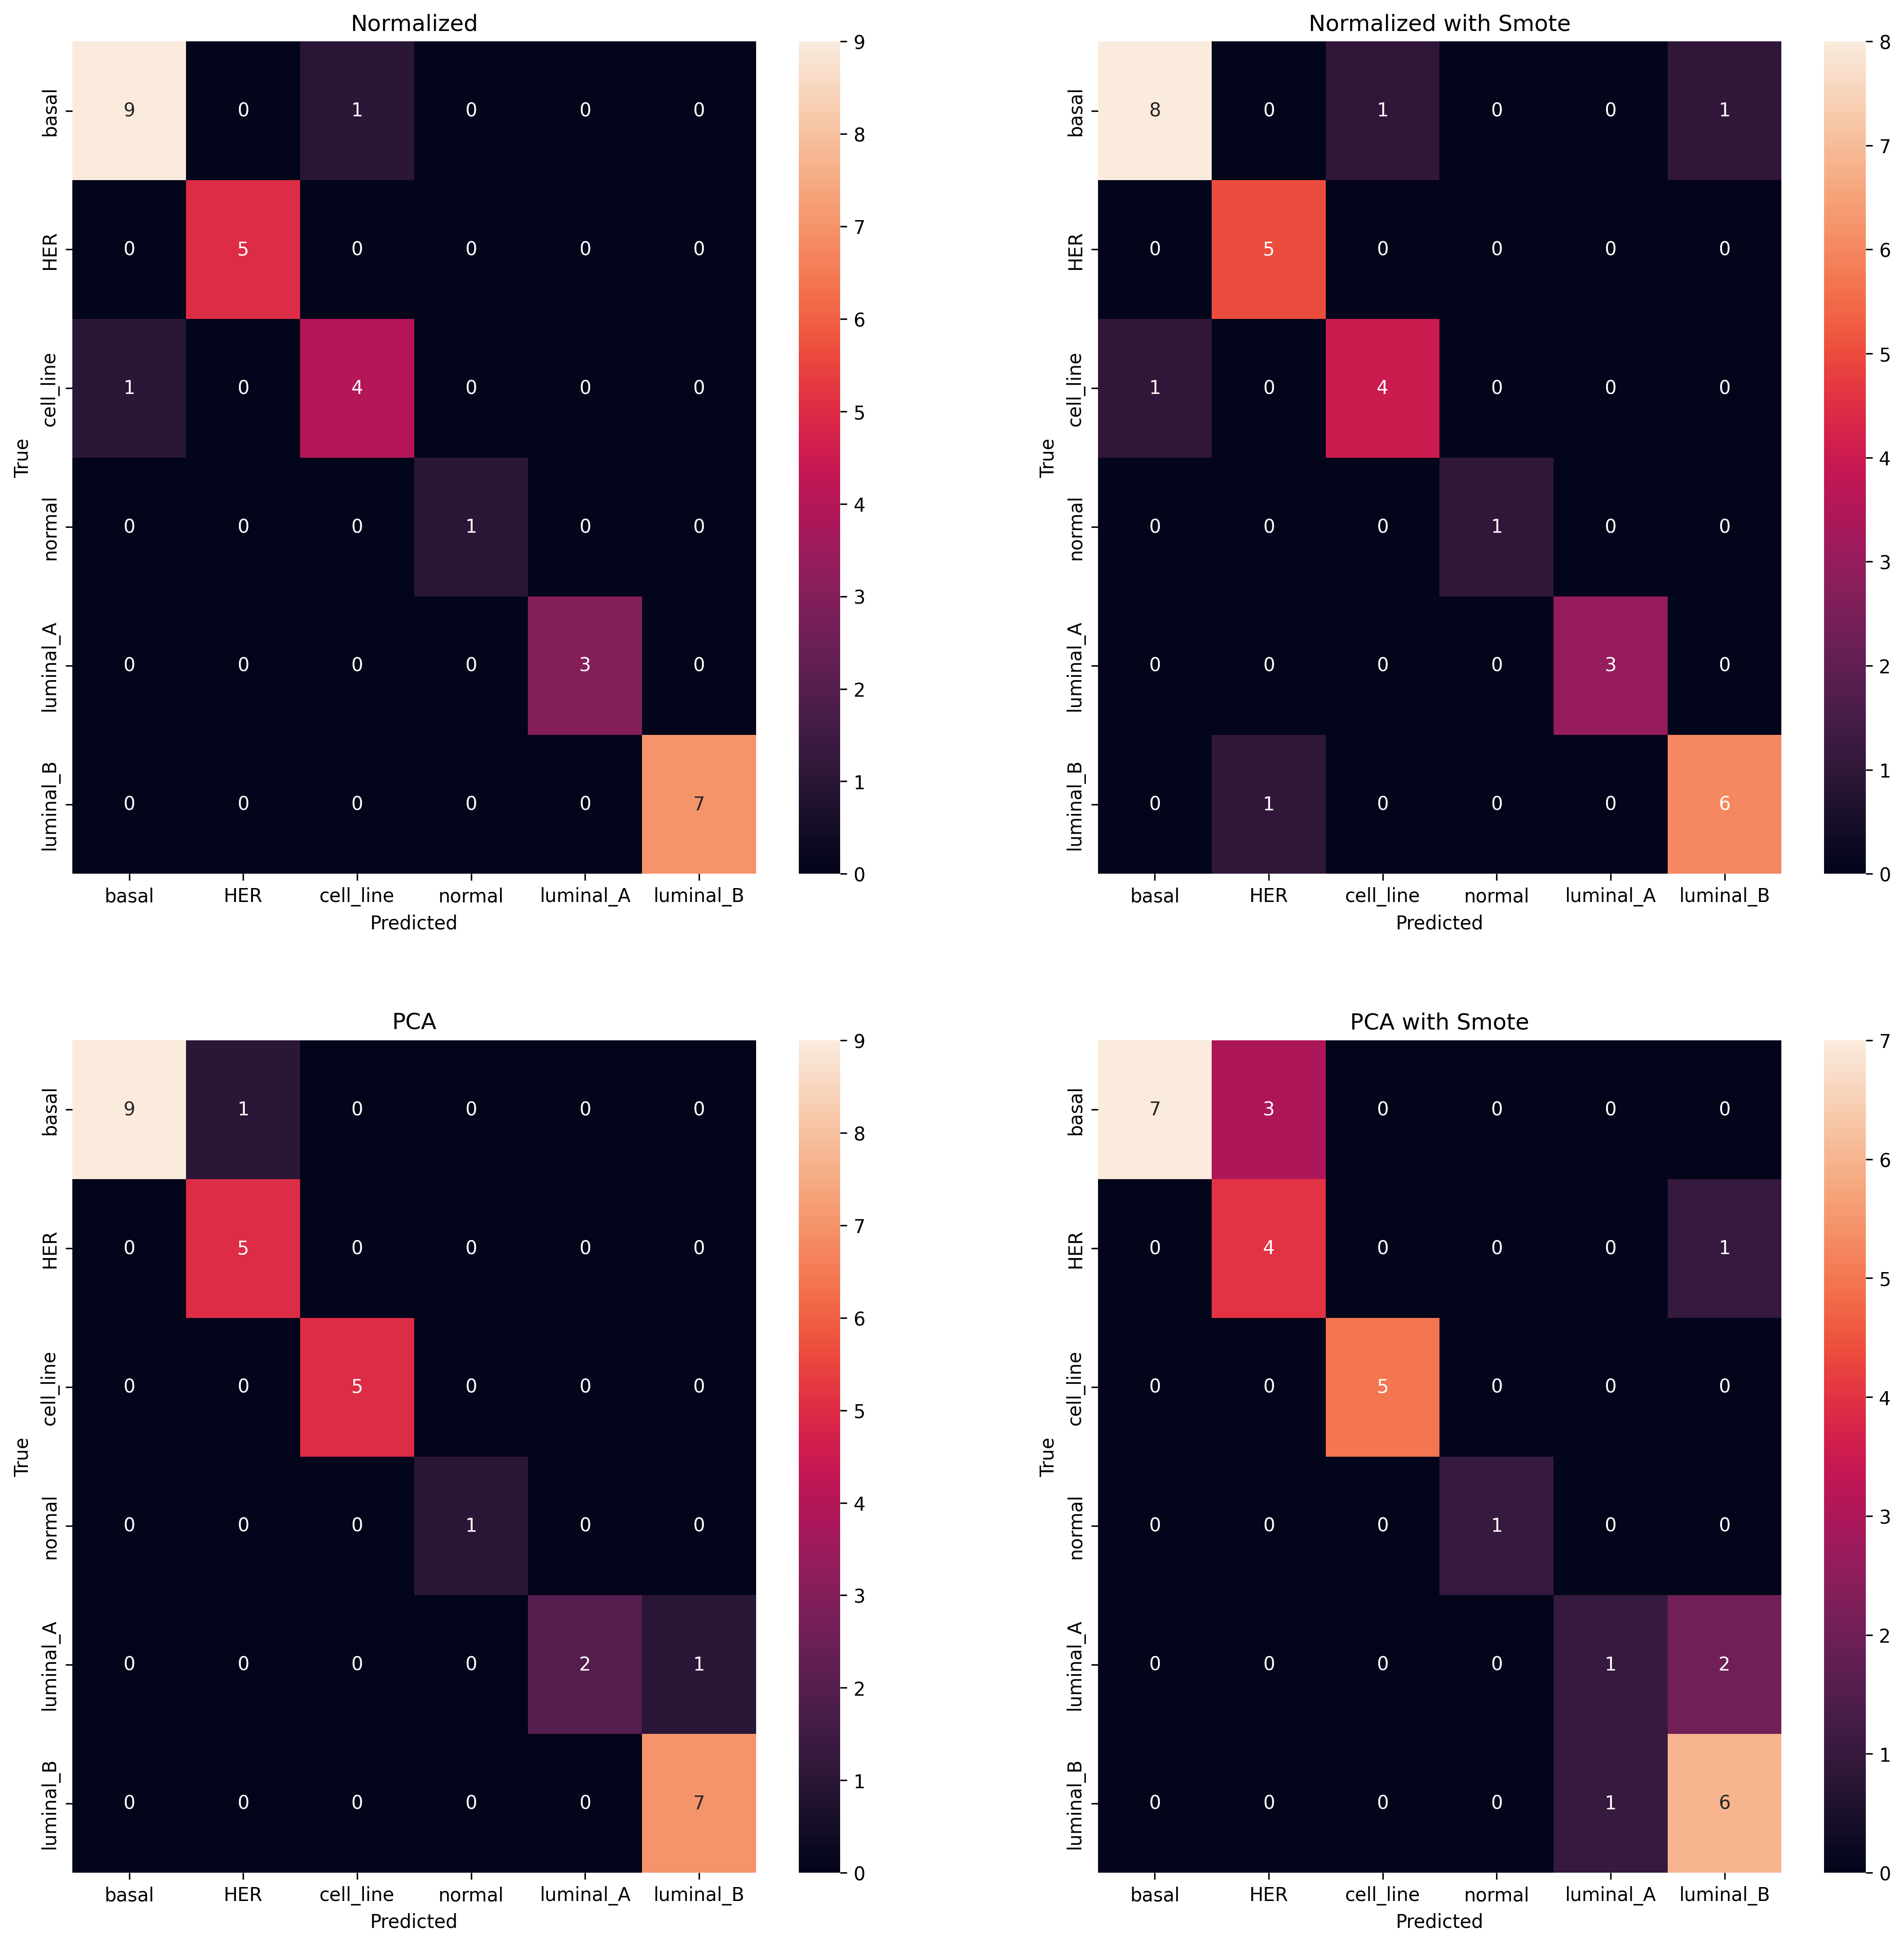

In [46]:
plt.figure(figsize=(18, 18), dpi=300)
plt.subplot(2, 2, 1)
plt.title('Normalized')
sns.heatmap(confusion_matrix(norm_true, norm_pred), annot=True, xticklabels=class_mapping, yticklabels=class_mapping, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(2, 2, 2)
plt.title('Normalized with Smote')
sns.heatmap(confusion_matrix(norm_res_true, norm_res_pred), xticklabels=class_mapping, yticklabels=class_mapping, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(2, 2, 3)
plt.title('PCA')
sns.heatmap(confusion_matrix(pca_true, pca_pred), annot=True, xticklabels=class_mapping, yticklabels=class_mapping, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(2, 2, 4)
plt.title('PCA with Smote')
sns.heatmap(confusion_matrix(pca_res_true, pca_res_pred), xticklabels=class_mapping, yticklabels=class_mapping, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

# save figure
if not os.path.exists('../../figures/XGBoost'):
    os.makedirs('../../figures/XGBoost')

plt.savefig('../../figures/XGBoost/XGBoost Confusion Matrix.png', dpi=300)

plt.show()

## Save Models

In [38]:
if not os.path.exists(models_path):
    os.makedirs(models_path)

print('Saving models...', models_path)
pickle.dump(norm_model, open(models_path + 'norm_model.pickle', "wb"))
pickle.dump(norm_res_model, open(models_path + 'norm_res_model.pickle', "wb"))

pickle.dump(pca_model, open(models_path + 'pca_model.pickle', "wb"))
pickle.dump(pca_res_model, open(models_path + 'pca_res_model.pickle', "wb"))

Saving models... saved_models/XGBoost/
